In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']

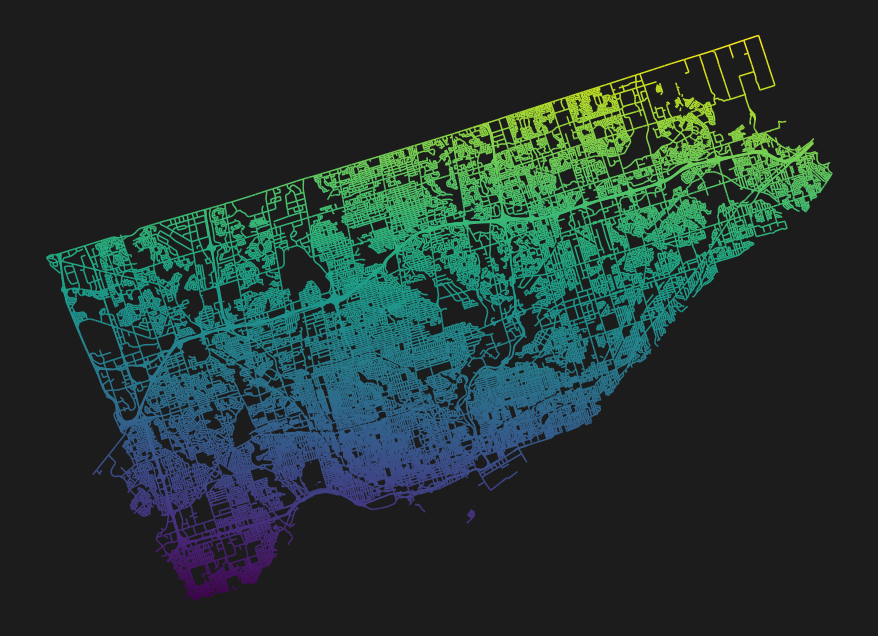

In [2]:
import geopandas as gpd

sql_query = ("SELECT centreline_id, fcode_desc, geom, lon, lat,"
             "ST_SetSRID(ST_MakePoint(lon, lat), 4326) point_geom "
             "FROM {table}").format(table=ll_conn.tablename)
ctrline_geoms = gpd.read_postgis(sql_query, ll_conn.connect())

# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
fig = plt.figure(figsize=(12, 9))
#fig.patch.set_visible(False)
fig.patch.set_facecolor('#1c1c1c')
ax = fig.add_axes([0., 0., 1., 1.])
ax.axis('off')
ctrline_geoms[['geom', 'lat']].to_crs(epsg=3857).plot(column='lat', ax=ax, cmap='viridis')

In [10]:
from plotly import graph_objs as go
from plotly import offline as ploff
from matplotlib import colors as mpl_colors
from matplotlib import cm as mpl_cm

ploff.init_notebook_mode(connected=True)
plas_cmap = mpl_cm.get_cmap('plasma_r')

import numpy as np

ctrline_geoms['rands'] = np.random.rand(ctrline_geoms.shape[0])

data = [
    go.Scattermapbox(
        lat=ctrline_geoms['lat'].values,
        lon=ctrline_geoms['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=5.,
            color=[mpl_colors.rgb2hex(plas_cmap(x)[:3])
                   for x in ctrline_geoms['rands'].values],
        ),
        name='',
    ),
]

layout = go.Layout(
    autosize=True,
    height=600,
    mapbox=dict(
        accesstoken=MAPBOX_TOKEN,
        bearing=0,
        center=dict(lat=43.6932, lon=-79.3632),
        pitch=0,
        zoom=10,
        style='mapbox://styles/czhubditto/ck30d5fuu0vvr1cnvvwv82oqr'
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=False,
)

fig = dict(data=data, layout=layout)
ploff.iplot(fig)